In [48]:
import matplotlib as mpl
#mpl.use('TkAgg')
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from sklearn.cross_validation import train_test_split
import graphlab as gl
import io
import requests
%matplotlib inline

In [49]:
col_names = ["user_id", "item_id", "rating", "timestamp" ]
url = "https://raw.githubusercontent.com/Harpreet1984/DATA643/master/Proj2/Data/ratings.data"
s=requests.get(url).content
data = pd.read_table(io.StringIO(s.decode('utf-8')), names=col_names)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
user_id      100000 non-null int64
item_id      100000 non-null int64
rating       100000 non-null int64
timestamp    100000 non-null int64
dtypes: int64(4)
memory usage: 3.1 MB


(array([  6110.,      0.,  11370.,      0.,      0.,  27145.,      0.,
         34174.,      0.,  21201.]),
 array([ 1. ,  1.4,  1.8,  2.2,  2.6,  3. ,  3.4,  3.8,  4.2,  4.6,  5. ]),
 <a list of 10 Patch objects>)

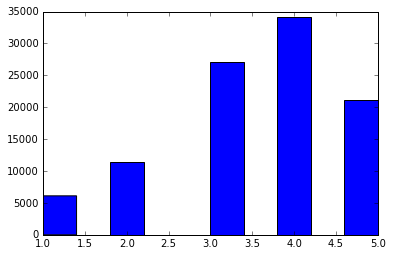

In [50]:
plt.hist(data["rating"])

## subsetting the data, by not including users that have less than 50 ratings, So that we can maximize sparsity.

In [51]:
users = data["user_id"]
rating_count = {}
for user in users :
    if user in rating_count :
        rating_count[user] += 1
    else :
        rating_count[user] = 1
RATING_CUTOFF = 50
remove_user = []
for user in rating_count :
    if rating_count[user] < RATING_CUTOFF:
        remove_user.append(user)
    
data = data.loc[~ data["user_id"].isin(remove_user) ]


## Prepare for graphlab

In [52]:
sframe=gl.SFrame(data)
print (sframe)

+---------+---------+--------+-----------+
| user_id | item_id | rating | timestamp |
+---------+---------+--------+-----------+
|   186   |   302   |   3    | 891717742 |
|    22   |   377   |   1    | 878887116 |
|   244   |    51   |   2    | 880606923 |
|   298   |   474   |   4    | 884182806 |
|   115   |   265   |   2    | 881171488 |
|   253   |   465   |   5    | 891628467 |
|   305   |   451   |   3    | 886324817 |
|    6    |    86   |   3    | 883603013 |
|    62   |   257   |   2    | 879372434 |
|   286   |   1014  |   5    | 879781125 |
+---------+---------+--------+-----------+
[88471 rows x 4 columns]
Note: Only the head of the SFrame is printed.
You can use print_rows(num_rows=m, num_columns=n) to print more rows and columns.


## Creating Train, Validate, Test split 

In [53]:
sframe_train, sframe_test = sframe.random_split(.7)
sframe_train, sframe_validate = sframe_train.random_split(.75)

## Popularity Recommender

In [54]:
popularity_recommender = gl.recommender.popularity_recommender.create(sframe_train, target='rating')
popularity_recommender.evaluate_rmse(sframe_test, 'rating')
popularity_recommender

Recsys training: model = popularity

Warning: Ignoring columns timestamp;

To use these columns in scoring predictions, use a model that allows the use of additional features.

Preparing data set.

Data has 46466 observations with 568 users and 1580 items.

Data prepared in: 0.117014s

46466 observations to process; with 1580 unique items.

Class                            : PopularityRecommender

Schema
------
User ID                          : user_id
Item ID                          : item_id
Target                           : rating
Additional observation features  : 0
User side features               : []
Item side features               : []

Statistics
----------
Number of observations           : 46466
Number of users                  : 568
Number of items                  : 1580

Training summary
----------------
Training time                    : 0.005

Model Parameters
----------------
Model class                      : PopularityRecommender

## User to User Collaborative Recommender

In [55]:
regularization_terms = [10**-5,10**-4,10**-3,10**-2,10**-1]
best_regularization_term=0
best_RMSE = np.inf
for regularization_term in regularization_terms:
    factorization_recommender = gl.recommender.factorization_recommender.create(sframe_train, target='rating', regularization=regularization_term )
    evaluation = factorization_recommender.evaluate_rmse(sframe_validate, 'rating')
    if evaluation['rmse_overall'] < best_RMSE :
        best_RMSE = evaluation['rmse_overall']
        best_regularization_term = regularization_term
print ("Best Regularization Term " + str(best_regularization_term))
print ("Best Validation RMSE Achieved " +  str(best_RMSE))       

factorization_recommender = gl.recommender.factorization_recommender.create(sframe_train, target= 'rating', regularization=best_regularization_term)

  

Recsys training: model = factorization_recommender

Preparing data set.

Data has 46466 observations with 568 users and 1580 items.

Data prepared in: 0.14001s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 8        |

| regularization                 | L2 Regularization on Factors                     | 1e-005   |

| solver                         | Solver used for training                         | adagrad  |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-010   |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 46466 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 16.6667           | Not Viable                               |

| 1       | 4.16667           | Not Viable                               |

| 2       | 1.04167           | Not Viable                               |

| 3       | 0.260417          | 0.789165                                 |

| 4       | 0.130208          | 0.51463                                  |

| 5       | 0.0651042         | 0.591081                                 |

| 6       | 0.0325521         | 0.765503                                 |

| 7       | 0.016276          | 0.93034                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.130208          | 0.51463                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 1.004ms      | 1.26279           | 1.12374               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 166.999ms    | 1.09038           | 1.04341               | 0.130208    |

| 2       | 323.995ms    | 0.882065          | 0.938128              | 0.130208    |

| 3       | 444.995ms    | 0.853129          | 0.922399              | 0.130208    |

| 4       | 572.994ms    | 0.826818          | 0.907786              | 0.130208    |

| 5       | 677.995ms    | 0.812382          | 0.899596              | 0.130208    |

| 6       | 808.991ms    | 0.799357          | 0.892151              | 0.130208    |

| 10      | 1.17s        | 0.756674          | 0.867196              | 0.130208    |

| 11      | 1.29s        | 0.749691          | 0.862984              | 0.130208    |

| 20      | 2.70s        | 0.691716          | 0.827196              | 0.130208    |

| 30      | 4.32s        | 0.640704          | 0.794112              | 0.130208    |

| 40      | 5.19s        | 0.602608          | 0.768237              | 0.130208    |

| 50      | 6.02s        | 0.570849          | 0.745848              | 0.130208    |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.550042

Final training RMSE: 0.731767

Recsys training: model = factorization_recommender

Preparing data set.

Data has 46466 observations with 568 users and 1580 items.

Data prepared in: 0.132997s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 8        |

| regularization                 | L2 Regularization on Factors                     | 0.0001   |

| solver                         | Solver used for training                         | adagrad  |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-010   |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 46466 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 15.8448           | Not Viable                               |

| 1       | 3.96119           | Not Viable                               |

| 2       | 0.990298          | Not Viable                               |

| 3       | 0.247575          | 0.42252                                  |

| 4       | 0.123787          | 0.540573                                 |

| 5       | 0.0618937         | 0.685376                                 |

| 6       | 0.0309468         | 0.812079                                 |

+---------+-------------------+------------------------------------------+

| Final   | 0.247575          | 0.42252                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 0us          | 1.26278           | 1.12373               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 112.999ms    | 1.84517           | 1.35169               | 0.247575    |

| 2       | 194ms        | 0.905189          | 0.939313              | 0.247575    |

| 3       | 272.994ms    | 0.873159          | 0.920094              | 0.247575    |

| 4       | 384.993ms    | 0.844421          | 0.901739              | 0.247575    |

| 5       | 472.995ms    | 0.827286          | 0.889763              | 0.247575    |

| 6       | 575.992ms    | 0.817613          | 0.882153              | 0.247575    |

| 11      | 997.987ms    | 0.774962          | 0.847575              | 0.247575    |

| 25      | 2.26s        | 0.71781           | 0.788857              | 0.247575    |

| 50      | 4.27s        | 0.680225          | 0.733333              | 0.247575    |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.664187

Final training RMSE: 0.722315

Recsys training: model = factorization_recommender

Preparing data set.

Data has 46466 observations with 568 users and 1580 items.

Data prepared in: 0.126s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 8        |

| regularization                 | L2 Regularization on Factors                     | 0.001    |

| solver                         | Solver used for training                         | adagrad  |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-010   |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 46466 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 1.58448           | Not Viable                               |

| 1       | 0.396119          | 0.806129                                 |

| 2       | 0.19806           | 0.772311                                 |

| 3       | 0.0990298         | 0.816803                                 |

| 4       | 0.0495149         | 0.890405                                 |

| 5       | 0.0247575         | 0.959497                                 |

+---------+-------------------+------------------------------------------+

| Final   | 0.19806           | 0.772311                                 |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 1.002ms      | 1.26279           | 1.12374               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 135.014ms    | 1.71189           | 1.29783               | 0.19806     |

| 2       | 243ms        | 0.89873           | 0.937253              | 0.19806     |

| 3       | 331.003ms    | 0.860917          | 0.919048              | 0.19806     |

| 4       | 479.994ms    | 0.846321          | 0.912355              | 0.19806     |

| 5       | 585.992ms    | 0.83933           | 0.909511              | 0.19806     |

| 6       | 710.989ms    | 0.834239          | 0.907442              | 0.19806     |

| 10      | 1.02s        | 0.824138          | 0.903729              | 0.19806     |

| 11      | 1.08s        | 0.823066          | 0.903496              | 0.19806     |

| 20      | 1.83s        | 0.815911          | 0.902101              | 0.19806     |

| 30      | 2.61s        | 0.813006          | 0.901287              | 0.19806     |

| 40      | 3.50s        | 0.811512          | 0.900582              | 0.19806     |

| 50      | 4.28s        | 0.810499          | 0.9                   | 0.19806     |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.804906

Final training RMSE: 0.896887

Recsys training: model = factorization_recommender

Preparing data set.

Data has 46466 observations with 568 users and 1580 items.

Data prepared in: 0.144994s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 8        |

| regularization                 | L2 Regularization on Factors                     | 0.01     |

| solver                         | Solver used for training                         | adagrad  |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-010   |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 46466 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.158448          | 0.721417                                 |

| 1       | 0.0792239         | 0.7901                                   |

| 2       | 0.0396119         | 0.899581                                 |

| 3       | 0.019806          | 1.02111                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.158448          | 0.721417                                 |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 999us        | 1.26277           | 1.12373               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 271.665ms    | 2.08338           | 1.43192               | 0.158448    |

| 2       | 521.49ms     | 0.872404          | 0.927409              | 0.158448    |

| 3       | 731.327ms    | 0.847646          | 0.918183              | 0.158448    |

| 4       | 935.782ms    | 0.83704           | 0.913966              | 0.158448    |

| 5       | 1.17s        | 0.831109          | 0.911304              | 0.158448    |

| 6       | 1.33s        | 0.82749           | 0.909535              | 0.158448    |

| 10      | 2.19s        | 0.82054           | 0.905834              | 0.158448    |

| 11      | 2.48s        | 0.819518          | 0.905271              | 0.158448    |

| 15      | 2.96s        | 0.816761          | 0.903749              | 0.158448    |

| 20      | 3.42s        | 0.814692          | 0.902603              | 0.158448    |

| 25      | 3.86s        | 0.813404          | 0.901889              | 0.158448    |

| 30      | 4.32s        | 0.812402          | 0.901333              | 0.158448    |

| 35      | 4.77s        | 0.811573          | 0.900874              | 0.158448    |

| 40      | 5.22s        | 0.811015          | 0.900564              | 0.158448    |

| 45      | 5.63s        | 0.81052           | 0.900289              | 0.158448    |

| 50      | 6.04s        | 0.8101            | 0.900055              | 0.158448    |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.805401

Final training RMSE: 0.897441

Recsys training: model = factorization_recommender

Preparing data set.

Data has 46466 observations with 568 users and 1580 items.

Data prepared in: 0.109s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 8        |

| regularization                 | L2 Regularization on Factors                     | 0.1      |

| solver                         | Solver used for training                         | adagrad  |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-010   |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 46466 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.0158448         | 1.05616                                  |

| 1       | 0.00792239        | 1.13638                                  |

| 2       | 0.00396119        | 1.18862                                  |

| 3       | 0.0019806         | 1.21758                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0158448         | 1.05616                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 0us          | 1.26279           | 1.12374               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 109.995ms    | 1.16953           | 1.07972               | 0.0158448   |

| 2       | 214.994ms    | 1.08654           | 1.04237               | 0.0158448   |

| 3       | 292.996ms    | 1.04746           | 1.02346               | 0.0158448   |

| 4       | 397.992ms    | 1.0211            | 1.01049               | 0.0158448   |

| 5       | 476.994ms    | 1.00146           | 1.00073               | 0.0158448   |

| 6       | 544.989ms    | 0.985963          | 0.992957              | 0.0158448   |

| 11      | 932.985ms    | 0.939229          | 0.969138              | 0.0158448   |

| 25      | 2.09s        | 0.891438          | 0.94416               | 0.0158448   |

| 50      | 4.59s        | 0.864997          | 0.930052              | 0.0158448   |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.864189

Final training RMSE: 0.929618

Best Regularization Term 0.01
Best Validation RMSE Achieved 0.941334138331


Recsys training: model = factorization_recommender

Preparing data set.

Data has 46466 observations with 568 users and 1580 items.

Data prepared in: 0.094012s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 8        |

| regularization                 | L2 Regularization on Factors                     | 0.01     |

| solver                         | Solver used for training                         | adagrad  |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-010   |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 46466 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.158448          | Not Viable                               |

| 1       | 0.0396119         | 0.910387                                 |

| 2       | 0.019806          | 1.03174                                  |

| 3       | 0.00990298        | 1.12922                                  |

| 4       | 0.00495149        | 1.19513                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0396119         | 0.910387                                 |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 0us          | 1.26279           | 1.12374               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 119.999ms    | 1.08953           | 1.033                 | 0.0396119   |

| 2       | 282.996ms    | 0.964155          | 0.981914              | 0.0396119   |

| 3       | 548.989ms    | 0.924857          | 0.961695              | 0.0396119   |

| 4       | 687.99ms     | 0.903461          | 0.950506              | 0.0396119   |

| 5       | 823.991ms    | 0.88967           | 0.943223              | 0.0396119   |

| 6       | 1.00s        | 0.879926          | 0.938044              | 0.0396119   |

| 10      | 1.47s        | 0.858655          | 0.926636              | 0.0396119   |

| 11      | 1.57s        | 0.855528          | 0.924948              | 0.0396119   |

| 20      | 2.28s        | 0.839798          | 0.916405              | 0.0396119   |

| 30      | 3.19s        | 0.832098          | 0.912194              | 0.0396119   |

| 40      | 4.11s        | 0.827731          | 0.909797              | 0.0396119   |

| 50      | 5.07s        | 0.824785          | 0.908177              | 0.0396119   |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.823452

Final training RMSE: 0.907443

## Item to Item Collaborative Recommender

In [56]:
item_similarity_recommender = gl.recommender.item_similarity_recommender.create(sframe_train, target= "rating") 
 

Recsys training: model = item_similarity

Warning: Ignoring columns timestamp;

To use these columns in scoring predictions, use a model that allows the use of additional features.

Preparing data set.

Data has 46466 observations with 568 users and 1580 items.

Data prepared in: 0.105s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 3.003ms                        | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 28.014ms                            | 0                | 0               |

| 211.995ms                           | 100              | 1580            |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

## Evaluating Model Performance

With recommender systems, we can evaluate models using two different metrics, RMSE and precision-recall. RMSE measures how well the model predicts the score of the user, while precision-recall measures how well the recommend() function recommends items that the user also chooses. For example, the best RMSE value is when the model exactly predicts the value of all the ratings in the test set. Similarly, the best precision-recall value is when the user has 5 items in the test set and recommend() recommends exactly those 5 items. While both can be important depending on the type of data and desired task, precision-recall is often more useful in evaluating how well a recommender system will perform in practice.
Once training and test set are generated, the gl.recommender.util.compare_models function allows easy evaluation of several models using either RMSE or precision-recall. These models may the same models with different parameters or completely different types of model.


## RMSE comparision

In [57]:
print ("Test RMSE on Popularity filtering " + str (popularity_recommender.evaluate_rmse(sframe_test, 'rating')['rmse_overall']))
print ("Test RMSE on User to User Collaborative filtering " + str (factorization_recommender.evaluate_rmse(sframe_test, 'rating')['rmse_overall']))
print ("Test RMSE on Item to Item Collaborative filtering " +  str( item_similarity_recommender.evaluate_rmse(sframe_test, "rating")["rmse_overall"]))  

Finished training in 0.222997s

Test RMSE on Popularity filtering 1.02712241805
Test RMSE on User to User Collaborative filtering 0.939317033631
Test RMSE on Item to Item Collaborative filtering 3.67206778948


Based on the above RMSE stats, User to User Collaborative filtering provides a better model.

## Precision/recall matrix for each model.

In [58]:
models = [popularity_recommender, factorization_recommender, item_similarity_recommender]
model_names = ['popularity', 'factorization', 'item_similarity']
precision_recall = gl.recommender.util.compare_models(sframe_test, models, metric='precision_recall', model_names=model_names)
precision_recall

PROGRESS: Evaluate model popularity

Precision and recall summary statistics by cutoff
+--------+------------------+-------------------+
| cutoff |  mean_precision  |    mean_recall    |
+--------+------------------+-------------------+
|   1    | 0.00176056338028 | 2.75088028169e-05 |
|   2    | 0.00176056338028 | 5.30242141253e-05 |
|   3    | 0.00176056338028 | 9.30370182226e-05 |
|   4    | 0.00220070422535 | 0.000178213464796 |
|   5    | 0.00211267605634 | 0.000202330771376 |
|   6    | 0.00205399061033 | 0.000254112047266 |
|   7    | 0.00201207243461 | 0.000266338181852 |
|   8    | 0.00198063380282 |  0.0002749683945  |
|   9    | 0.00195618153365 | 0.000283598607148 |
|   10   | 0.00193661971831 | 0.000292228819797 |
+--------+------------------+-------------------+
[10 rows x 3 columns]

PROGRESS: Evaluate model factorization

Precision and recall summary statistics by cutoff
+--------+----------------+------------------+
| cutoff | mean_precision |   mean_recall    |
+-----

[{'precision_recall_by_user': Columns:
  	user_id	int
  	cutoff	int
  	precision	float
  	recall	float
  	count	int
  
  Rows: 10224
  
  Data:
  +---------+--------+-----------+--------+-------+
  | user_id | cutoff | precision | recall | count |
  +---------+--------+-----------+--------+-------+
  |    1    |   1    |    0.0    |  0.0   |   70  |
  |    1    |   2    |    0.0    |  0.0   |   70  |
  |    1    |   3    |    0.0    |  0.0   |   70  |
  |    1    |   4    |    0.0    |  0.0   |   70  |
  |    1    |   5    |    0.0    |  0.0   |   70  |
  |    1    |   6    |    0.0    |  0.0   |   70  |
  |    1    |   7    |    0.0    |  0.0   |   70  |
  |    1    |   8    |    0.0    |  0.0   |   70  |
  |    1    |   9    |    0.0    |  0.0   |   70  |
  |    1    |   10   |    0.0    |  0.0   |   70  |
  +---------+--------+-----------+--------+-------+
  [10224 rows x 5 columns]
  Note: Only the head of the SFrame is printed.
  You can use print_rows(num_rows=m, num_columns=n) t

The precision is the proportion of recommendations that are good recommendations, and recall is the proportion of good recommendations that appear in top recommendations.
Based on the above stats Item to Item collaborative filtering gives a better model.